net1: [(0, 2, 3), (0, 3, 3), (0, 4, 3), (0, 5, 3), (0, 5, 4), (0, 5, 5), (0, 5, 6), (1, 5, 6), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 5, 9), (1, 6, 9), (1, 7, 9), (1, 8, 9), (0, 8, 9)]


/var/folders/xg/3jnnfc6j05s268t2dgjnh3v40000gn/T/ipykernel_62615/3305604376.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Greens")  # Color map for free cells


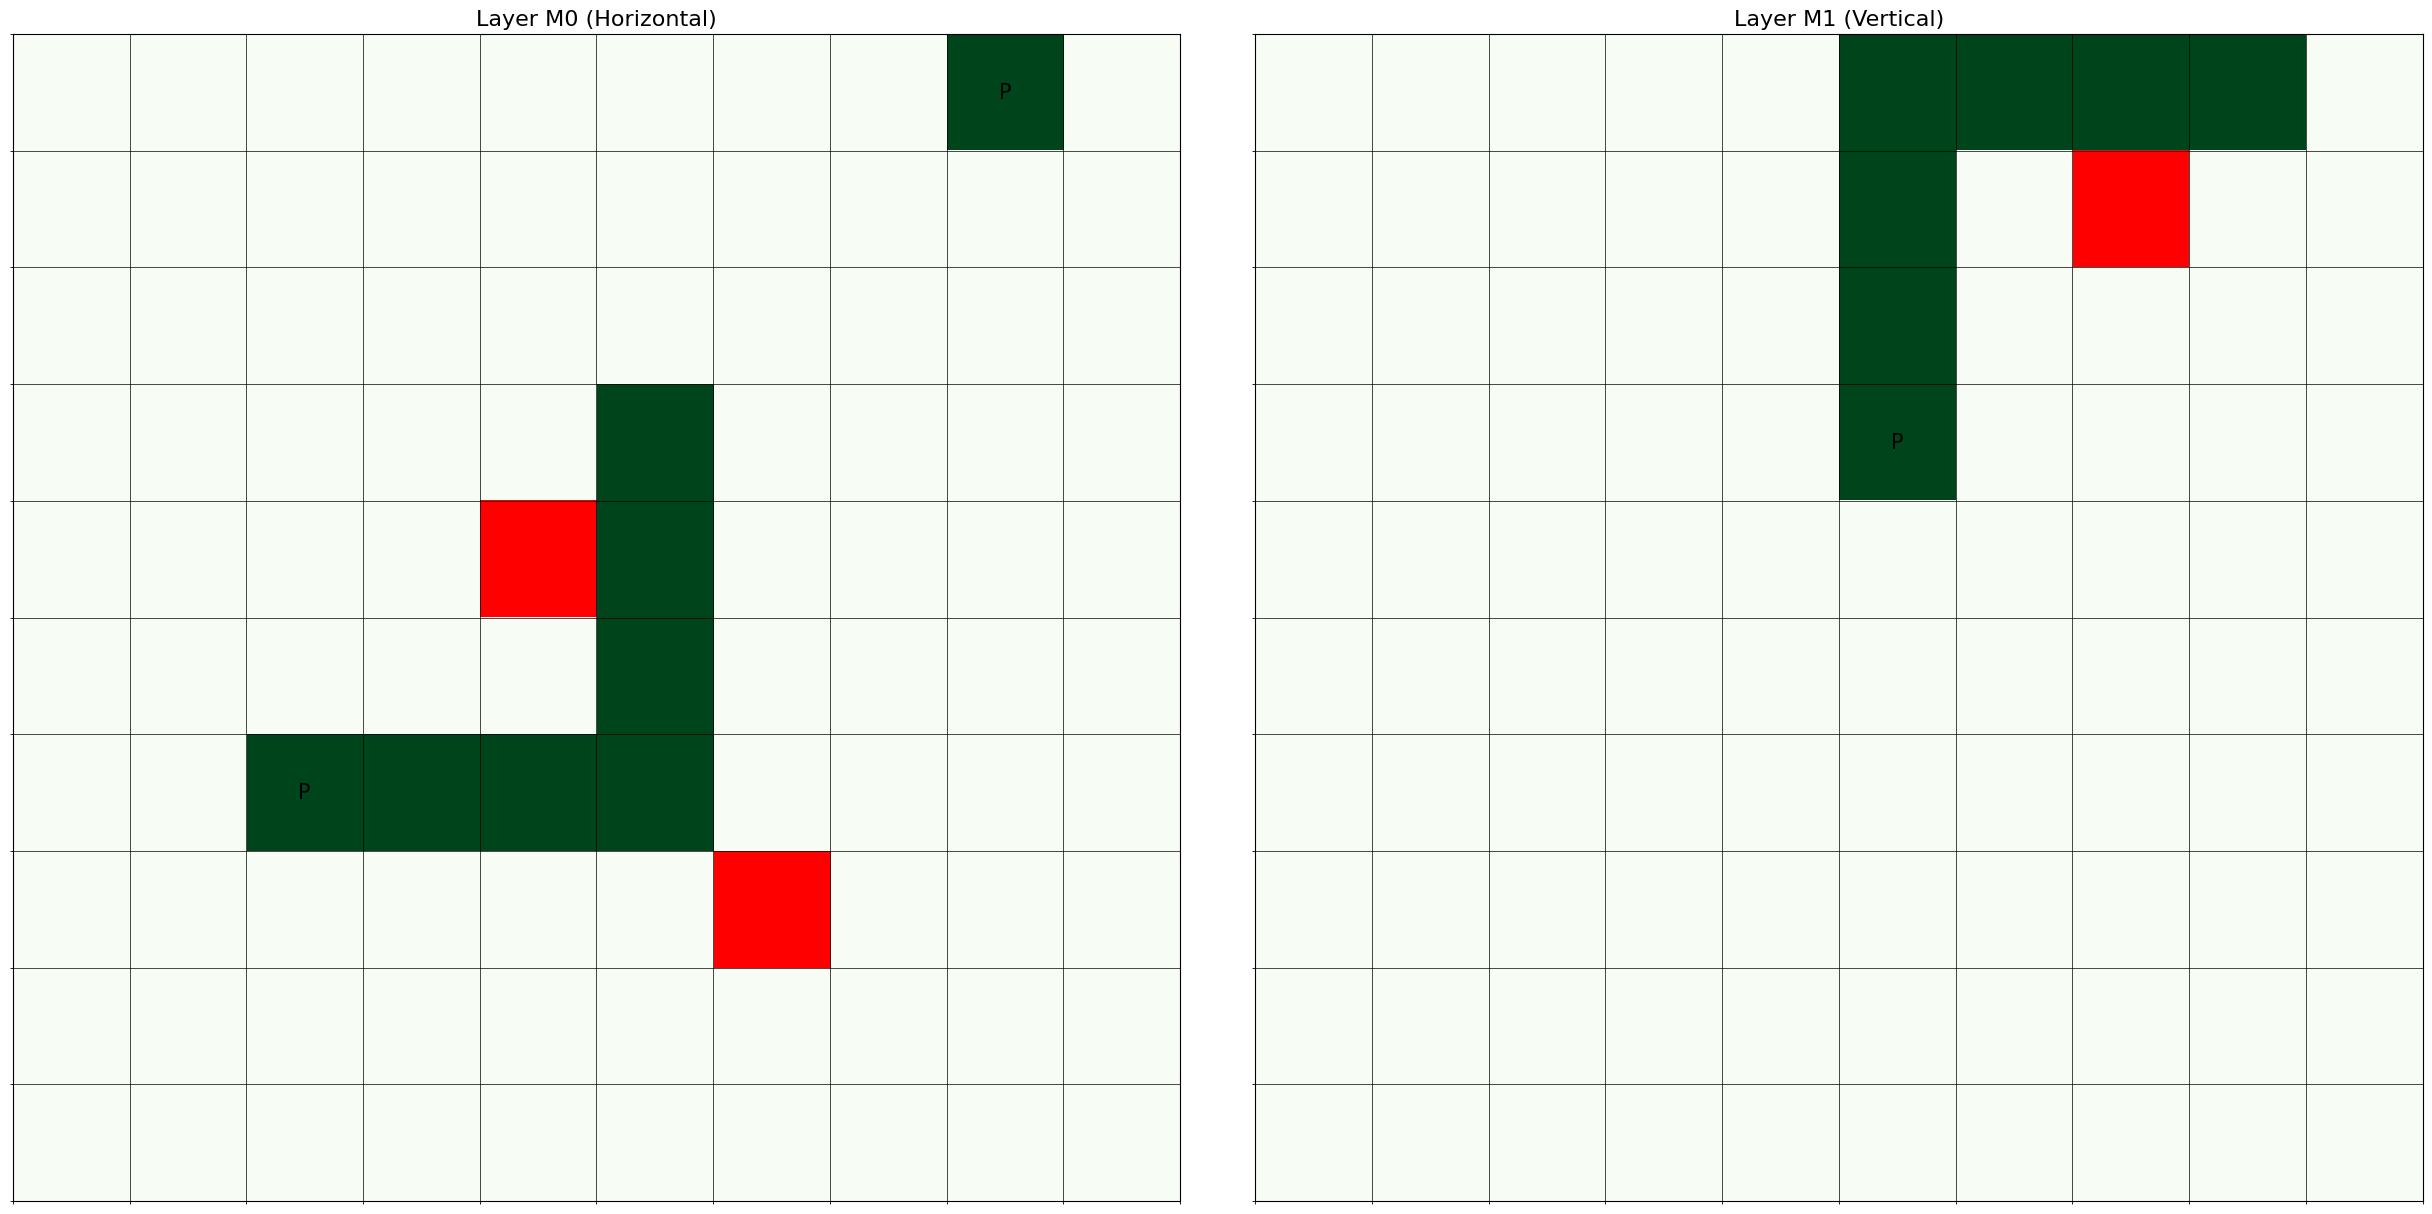

In [26]:
# Global grid representation
import re
import matplotlib.pyplot as plt
import numpy as np
import heapq

# Global variables
grid_dimensions = None
bend_penalty = None
via_penalty = None
obstructions = []
nets = {}
grid = []

# Function to parse the input file
def parse_input_file(file_path):
    global grid_dimensions, bend_penalty, via_penalty, obstructions, nets

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse the grid dimensions and penalties
    grid_info = list(map(int, lines[0].strip().split(',')))
    grid_dimensions = (grid_info[0], grid_info[1])  # NxM grid
    bend_penalty = grid_info[2]
    via_penalty = grid_info[3]

    # Parse the obstructions
    for line in lines[1:]:
        if line.startswith("OBS"):
            match = re.search(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            if match:
                obstructions.append((int(match.group(1)), int(match.group(2)), int(match.group(3))))

    # Parse the nets
    for line in lines[1:]:
        if line.startswith("net"):
            net_name = line.split(' ')[0]
            net_points = re.findall(r"\((\d+),\s*(\d+),\s*(\d+)\)", line)
            nets[net_name] = [(int(layer), int(x), int(y)) for layer, x, y in net_points]
def initialize_grid():
    global grid, grid_dimensions, obstructions, nets

    # Extract dimensions
    rows, cols = grid_dimensions

    # Create a 3D list for two layers, each initialized with default cost (0 for simplicity)
    grid = [[[{'cost': 0, 'obstruction': False, 'used_in_path': False, 'pin': False} for _ in range(cols)] for _ in range(rows)] for _ in range(2)]

    # Mark obstructions
    for layer, x, y in obstructions:
        grid[layer][x][y]['obstruction'] = True
        grid[layer][x][y]['cost'] = float('inf')  # Assign a high cost to obstructions
    for net in nets:
        for layer, x, y in nets[net]:
            grid[layer][x][y]['pin'] = True


def visualize_3d_grid_matplotlib():
    global grid, grid_dimensions

    # Extract grid dimensions
    rows, cols = grid_dimensions

    # Prepare two grid matrices for the layers
    grid_matrix_layer0 = np.zeros((cols, rows), dtype=int)
    grid_matrix_layer1 = np.zeros((cols, rows), dtype=int)

    for layer in range(2):
        for row in range(rows):
            for col in range(cols):
                if grid[layer][row][col]['obstruction']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = -1
                    else:
                        grid_matrix_layer1[col][row] = -1
                if grid[layer][row][col]['used_in_path']:
                    if layer == 0:
                        grid_matrix_layer0[col][row] = 1
                    else:
                        grid_matrix_layer1[col][row] = 1
                

    # Create a side-by-side visualization of the two layers
    fig, axes = plt.subplots(1, 2, figsize=(25, 12))  # One subplot for each layer

    cmap = plt.cm.get_cmap("Greens")  # Color map for free cells
    cmap.set_under(color="red")
    cmap.set_over(color="green")  # Red for obstructions

    # Plot Layer 0
    axes[0].imshow(grid_matrix_layer0, cmap=cmap, vmin=0, vmax=1, origin='lower')
    axes[0].set_title("Layer M0 (Horizontal)", fontsize=16)
    axes[0].set_xticks(np.arange(-0.5, cols, 1), minor=True)
    axes[0].set_yticks(np.arange(-0.5, rows, 1), minor=True)
    axes[0].grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    axes[0].set_aspect('equal')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    for i in range(rows):
        for j in range(cols):
            if grid[0][i][j]['pin']:
                axes[0].text(i, j, 'P', ha='center', va='center', color='black',fontsize=15)
    # Plot Layer 1
    axes[1].imshow(grid_matrix_layer1, cmap=cmap, vmin=0, vmax=1, origin='lower')
    axes[1].set_title("Layer M1 (Vertical)", fontsize=16)
    axes[1].set_xticks(np.arange(-0.5, cols, 1), minor=True)
    axes[1].set_yticks(np.arange(-0.5, rows, 1), minor=True)
    axes[1].grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    axes[1].set_aspect('equal')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    for i in range(rows):
        for j in range(cols):
            if grid[1][i][j]['pin']:
                axes[1].text(i, j, 'P', ha='center', va='center', color='black',fontsize=15)
    # Show the plot
    plt.tight_layout()
    plt.show()
def order_nets_by_pins(nets):
    # Sort nets by the number of pins (ascending order)
    return sorted(nets.items(), key=lambda x: len(x[1]))

from collections import deque

def find_path(grid, source, target, bend_penalty, via_penalty):
    rows = len(grid[0])
    cols = len(grid[0][0])

    # Directions for neighbors: (layer, dx, dy)
    directions = {
        0: [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)],  # Horizontal layer
        1: [(0, 0, 1), (0, 0, -1), (0, 1, 0), (0, -1, 0), (1, 0, 0), (-1, 0, 0)]   # Vertical layer
    }
    
    # Preferred directions for each layer
    preferred = {
        0: (0, 1),  # Horizontal: (dx, dy)
        1: (1, 0)   # Vertical: (dx, dy)
    }

    # Priority queue: (cost, (layer, x, y), previous_direction)
    pq = []
    heapq.heappush(pq, (0, source, None))  # Cost to reach source is 0

    # Distance dictionary to track the minimum cost to each cell
    dist = {}
    dist[source] = 0

    # Parent dictionary to reconstruct the path
    parent = {}

    while pq:
        # Pop the cell with the smallest cost
        current_cost, (layer, x, y), prev_direction = heapq.heappop(pq)

        # Stop if we reach the target
        if (layer, x, y) == target:
            # Reconstruct the path from the parent dictionary
            path = []
            current = target
            while current in parent:
                path.append(current)
                current = parent[current]
            path.append(source)
            return path[::-1]  # Reverse the path to get source to target

        # Skip if this state has already been processed with a smaller cost
        if (layer, x, y) in dist and current_cost > dist[(layer, x, y)]:
            continue

        # Explore neighbors
        for dlayer, dx, dy in directions[layer]:
            nx, ny = x + dx, y + dy
            nlayer = layer + dlayer

            # Check boundaries and obstructions
            if 0 <= nx < rows and 0 <= ny < cols and 0 <= nlayer < 2 and not grid[nlayer][nx][ny]['obstruction']:

                # Calculate the cost to move to the neighbor
                move_cost = grid[nlayer][nx][ny]['cost']
                new_cost = current_cost + move_cost

                # Add bend penalty if direction changes from preferred direction
                if prev_direction is not None:
                    preferred_dx, preferred_dy = preferred[layer]
                    if (dx, dy) != prev_direction and (dx, dy) != (preferred_dx, preferred_dy):
                        new_cost += bend_penalty

                # Add via penalty if transitioning layers
                if dlayer != 0:
                    new_cost += via_penalty

                # Update distance and add to priority queue if this path is better
                if (nlayer, nx, ny) not in dist or new_cost < dist[(nlayer, nx, ny)]:
                    dist[(nlayer, nx, ny)] = new_cost
                    parent[(nlayer, nx, ny)] = (layer, x, y)
                    heapq.heappush(pq, (new_cost, (nlayer, nx, ny), (dx, dy)))

    # If we reach here, the target is unreachable
    return []

def route_nets(grid, nets, bend_penalty, via_penalty):
    # Order nets by heuristic
    ordered_nets = order_nets_by_pins(nets)

    # Store results
    net_paths = {}

    for net_name, pins in ordered_nets:
        net_path = []
        for i in range(len(pins) - 1):
            # Route between pins using Lee's Algorithm
            path = find_path(grid, pins[i], pins[i+1], bend_penalty, via_penalty)
            net_path.extend(path)

        # Store the path for the net    
        net_paths[net_name] = net_path

        # Mark the routed path on the grid to avoid reuse
        for layer, x, y in net_path:
            grid[layer][x][y]['used_in_path'] = True

    return net_paths


if __name__ == "__main__":
    input_file = "input.txt"  # Replace with your input file path
    parse_input_file(input_file)  # Parse the input file
    initialize_grid()  # Initialize the 3D grid
    # Route the nets
    routed_nets = route_nets(grid, nets, bend_penalty, via_penalty)

    # Print the routed paths
    for net_name, path in routed_nets.items():
        print(f"{net_name}: {path}")
    visualize_3d_grid_matplotlib()
    

